In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas as gpd

plt.style.use('ggplot')
pd.set_option('display.max_columns', 30)

In [2]:
df = pd.read_csv('data/citibike_ZIP.csv')

In [3]:
# convert to geo dataframe
start_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(
    df['start_lon'], df['start_lat']), crs = 'epsg:4326')

# update projection 
start_gpd.to_crs(epsg=2263, inplace = True)

In [4]:
# remove duplicates for plotting
gpd_sub = start_gpd.drop_duplicates(['start_id'])
gpd_sub.shape

(958, 20)

In [5]:
# explore supply and demand
# find number of hourly trip starts and ends by station

starts_hrly = df.groupby(['hour','start_id'], as_index = False)[['bikeid']].count()
starts_hrly.columns = ['hour','start_id','start_count']
starts_hrly

,hour,start_id,start_count
0,0,72,45
1,0,79,11
2,0,82,4
3,0,83,35
4,0,116,32
...,...,...,...
22045,23,4020,45
22046,23,4023,26
22047,23,4036,19
22048,23,4037,5


In [6]:
ends_hrly = df.groupby(['hour','end_id'], as_index = False)[['bikeid']].count()
ends_hrly.columns = ['hour','end_id','end_count']
ends_hrly

,hour,end_id,end_count
0,0,72,53
1,0,79,8
2,0,82,10
3,0,83,17
4,0,116,40
...,...,...,...
22065,23,4021,1
22066,23,4023,40
22067,23,4036,11
22068,23,4037,8


In [8]:
supply_hrly = starts_hrly.merge(ends_hrly,
                               left_on = ['hour','start_id'],
                               right_on = ['hour','end_id'],
                               how = 'outer')
supply_hrly.head(5)

,hour,start_id,start_count,end_id,end_count
0,0,72.0,45.0,72.0,53.0
1,0,79.0,11.0,79.0,8.0
2,0,82.0,4.0,82.0,10.0
3,0,83.0,35.0,83.0,17.0
4,0,116.0,32.0,116.0,40.0


In [9]:
supply_hrly['start_count'].fillna(0, inplace=True)
supply_hrly['end_count'].fillna(0, inplace=True)

In [12]:
# define hourly surplus as the difference between hourly end count and start count at a station
# find daily average by dividing by 30

supply_hrly['hrly_surplus'] = (supply_hrly['end_count'] - supply_hrly['start_count'])/30
supply_hrly.sort_values(by = 'hrly_surplus').head(6)

,hour,start_id,start_count,end_id,end_count,hrly_surplus
14774,16,3141.0,1278.0,3141.0,524.0,-25.133333
15731,17,3141.0,1328.0,3141.0,653.0,-22.500000
13819,15,3141.0,919.0,3141.0,491.0,-14.266667
15126,16,3687.0,686.0,3687.0,320.0,-12.200000
14687,16,2012.0,529.0,2012.0,172.0,-11.900000
5137,6,492.0,410.0,492.0,54.0,-11.866667


In [13]:
supply_hrly.sort_values(by = 'hrly_surplus', ascending = False).head(6)

,hour,start_id,start_count,end_id,end_count,hrly_surplus
5270,6,3141.0,240.0,3141.0,1341.0,36.700000
5184,6,2012.0,113.0,2012.0,764.0,21.700000
5616,6,3687.0,143.0,3687.0,762.0,20.633333
5282,6,3156.0,118.0,3156.0,622.0,16.800000
6193,7,3141.0,928.0,3141.0,1349.0,14.033333
5379,6,3345.0,56.0,3345.0,466.0,13.666667


In [16]:
# separate hourly changes in supply for 5 stations with the greatest surplus/deficit peaks
supply_3141 = supply_hrly[supply_hrly['start_id'] == 3141]
supply_2012 = supply_hrly[supply_hrly['start_id'] == 2012]
supply_3687 = supply_hrly[supply_hrly['start_id'] == 3687]
supply_3156 = supply_hrly[supply_hrly['start_id'] == 3156]
supply_3345 = supply_hrly[supply_hrly['start_id'] == 3345]

In [17]:
# import zipcode shapefile
zip_shp = gpd.read_file('nyc_zip/ZIP_CODE_040114.shp')

[]

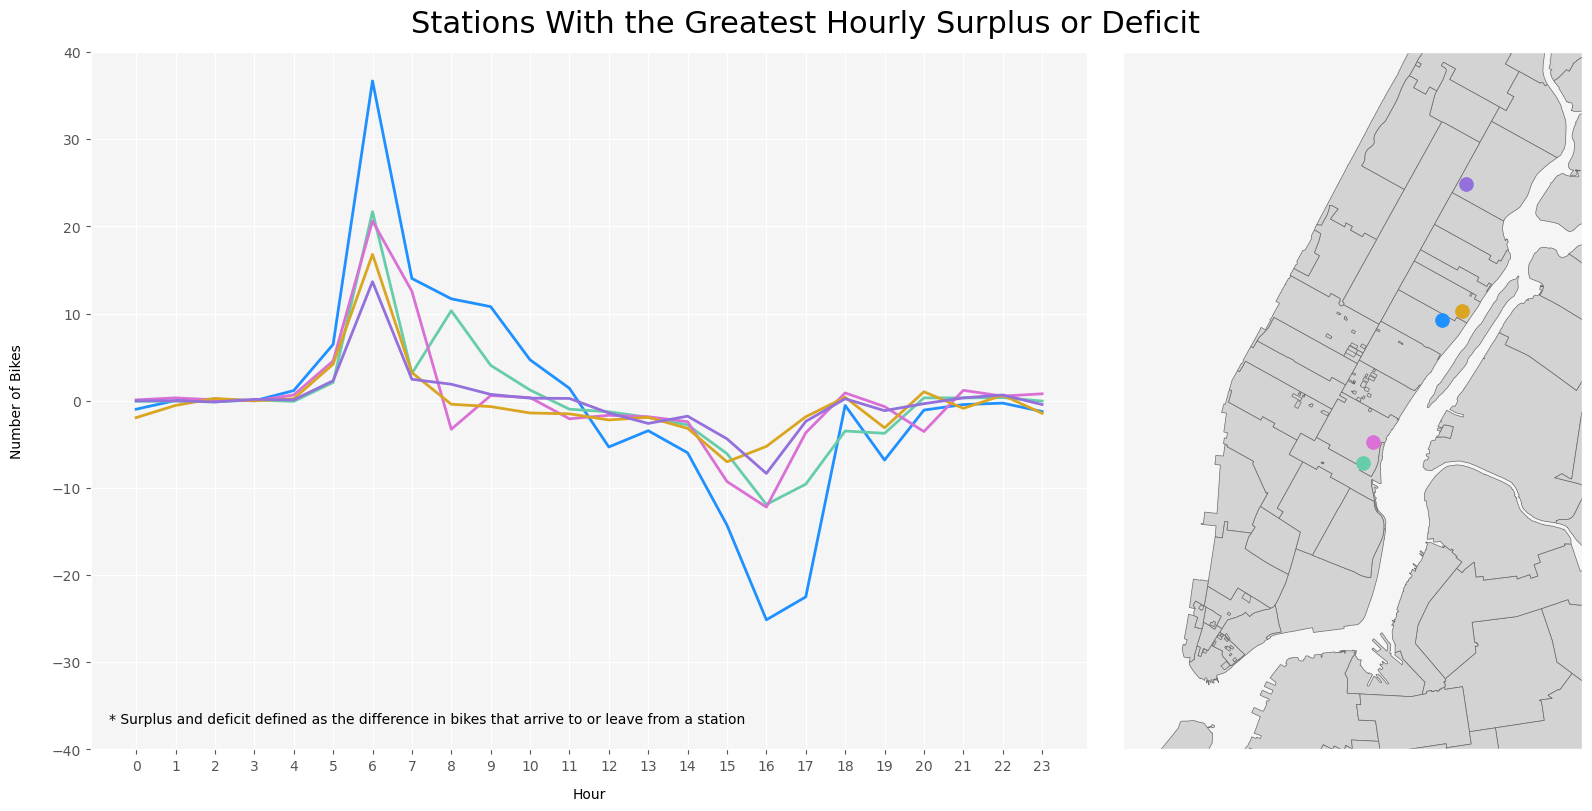

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,  
                        figsize=(16, 8), width_ratios = [2, 1],
                        sharex=False,
                        sharey=False,
                        constrained_layout=True)

fig.suptitle('Stations With the Greatest Hourly Surplus or Deficit', fontsize=22)

# line graph depicting hourly surplus and deficit for 5 stations

x = np.arange(24)
supply_3141.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'dodgerblue', linewidth = 2)
supply_2012.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'mediumaquamarine', linewidth = 2)
supply_3687.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'orchid', linewidth = 2)
supply_3156.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'goldenrod', linewidth = 2)
supply_3345.plot(ax=ax1, x = 'hour', y = 'hrly_surplus', color = 'mediumpurple', linewidth = 2)

ax1.set_xticks(x)
ax1.set_xlabel('Hour', labelpad = 10)
ax1.set_ylabel('Number of Bikes', labelpad = 20)
ax1.set_ylim(-40, 40)
ax1.set_facecolor("whitesmoke")
ax1.legend('', frameon = False)
ax1.text(-0.7, -37, '* Surplus and deficit defined as the difference in bikes that arrive to or leave from a station')

# point map showing station locations

zip_shp.plot(ax=ax2, color='lightgrey', edgecolor = 'dimgray')
gpd_sub[gpd_sub['start_id'] == 3141].plot(ax=ax2, markersize= 100, color = 'dodgerblue')
gpd_sub[gpd_sub['start_id'] == 2012].plot(ax=ax2, markersize= 100, color = 'mediumaquamarine')
gpd_sub[gpd_sub['start_id'] == 3687].plot(ax=ax2, markersize= 100, color = 'orchid')
gpd_sub[gpd_sub['start_id'] == 3156].plot(ax=ax2, markersize= 100, color = 'goldenrod')
gpd_sub[gpd_sub['start_id'] == 3345].plot(ax=ax2, markersize= 100, color = 'mediumpurple')

ax2.set_xlim(975000, 1005000)
ax2.set_ylim(190000, 235500)

ax2.set_facecolor("whitesmoke")
ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])